In [4]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import torch
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
np.random.seed(12345)


In [2]:
import paddle
gpu_available  = paddle.device.is_compiled_with_cuda()
print("GPU available:", gpu_available)

GPU available: True


In [5]:
torch.cuda.empty_cache()

In [4]:
#this dataframe consists of samples of both kyc as well as not_kyc classes
train_kyc_1=pd.read_csv("/home/intern/doc_classification_env/Data/train_combined_kyc_paddleocr.csv",usecols=['content','label'])
train_kyc_2=pd.read_csv("/home/intern/doc_classification_env/Data/train_only_kyc_updated.csv",usecols=['content','label'])
train_pa_1=pd.read_csv('/home/intern/doc_classification_env/Data/train_combined_pre_auths_paddleocr.csv',usecols=['content','label'])
train_pa_2=pd.read_csv("/home/intern/doc_classification_env/Data/train_only_pre_auths.csv",usecols=['content','label'])
train_ecard=pd.read_csv("/home/intern/doc_classification_env/Data/train_only_ecards.csv",usecols=['content','label'])
train_ecard_2=pd.read_csv("/home/intern/doc_classification_env/Data/train_extra_ecard.csv",usecols=['content','label'])
train_ds=pd.read_csv("/home/intern/doc_classification_env/Data/train_only_ds.csv",usecols=['content','label'])
train_others_1=pd.read_csv("/home/intern/doc_classification_env/Data/train_others_1.csv",usecols=['content','label'])
train_others_2=pd.read_csv("/home/intern/doc_classification_env/Data/train_others_2.csv",usecols=['content','label'])
train_others_3=pd.read_csv("/home/intern/doc_classification_env/Data/train_others_3.csv",usecols=['content','label'])
train_others_4=pd.read_csv("/home/intern/doc_classification_env/Data/train_others_4.csv",usecols=['content','label'])
train_others_5=pd.read_csv("/home/intern/doc_classification_env/Data/train_others_5.csv",usecols=['content','label'])

In [5]:
df_2=pd.concat([train_others_1,train_others_2,train_others_3,train_others_4,train_others_5])

In [6]:
df_1=pd.concat([train_pa_2,train_ecard,train_kyc_2,train_ecard_2])

In [7]:
train_kyc_1=train_kyc_1[train_kyc_1['label']=='kyc']
train_pa_1=train_pa_1[train_pa_1['label']=='pre_auth_form']

In [8]:
train_combined_df=pd.concat([df_1,train_kyc_1,train_pa_1,df_2,train_ds])

In [9]:
train_final=train_combined_df
train_final.reset_index(drop=True)

,content,label
0,"['ea1dN0.K0c-01-00000-000-0069834-A', 'REQUEST...",pre_auth_form
1,"['TO BEFILLED BY TREATING DOCTOR/HOSPITAL', 'J...",pre_auth_form
2,['fim naving read understood and agreed to the...,pre_auth_form
3,['REQUEST FORCASHLESS HOSPITALISATION FORHEALT...,pre_auth_form
4,"['TOBEFILLEDBYTREATINGDOCTOR/HOSPITAL', 'Thome...",pre_auth_form
...,...,...
1129,"['SRI RAMACHANDRA', 'Porur,Chennai -600 116.',...",ds
1130,"['Pages2/6', 'SRI RAMACHANDRA', 'Porur,Chennai...",ds
1131,"['Pages3/6', 'SRI RAMACHANDRA', 'Porur,Chennai...",ds
1132,"['mar', 'ARDIOTHORACICSURGERY', '122000000193-...",ds


In [10]:
train_1=train_final
nltk.download('stopwords')
stop_words=nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/intern/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(train_1['content'], train_1['label'], test_size=0.30, random_state=5,shuffle=True)

In [12]:
#uses unigrams to create features and only considers the top 200 features.
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = tokenizer.tokenize,max_features=100)
unigrams_count_train_1 = cv.fit_transform(X_train)
unigrams_count_test_1=cv.transform(X_test)

/home/intern/doc_classification_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
rfc=RandomForestClassifier(random_state=5)

In [21]:
#creating a hyperparameter grid which will be used by grid search as a sample hyperparameter space
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [10,25,50,100]
}

In [22]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy')

In [23]:
grid_search.fit(unigrams_count_train_1, Y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': [5, 10, 20, 30],
                         'max_features': [10, 25, 50, 100],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 30, 50, 70, 100]},
             scoring='accuracy')

In [24]:
#returns optimal hyperparameters along with best cv set score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Best Parameters:  {'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy: 93.06%


In [14]:
#initializing a RFC with the optimal hyperparameters suggested by Grid Search
rfc=RandomForestClassifier(random_state=5,max_depth= 30, max_features=10, min_samples_leaf= 2, min_samples_split=5, n_estimators= 50)
rfc.fit(unigrams_count_train_1,Y_train)
pred_rfc=rfc.predict(unigrams_count_test_1)

In [15]:
len=0
for val in Y_test:
    if val=='kyc':
        len+=1
print(len)  

67


In [16]:
len=0
for val in pred_rfc:
    if val=='kyc':
        len+=1
print(len)        

76


In [17]:
cat_list=['pre_auth_form', 'ecard', 'kyc', 'others', 'ds']
pa_count=0
ecard_count=0
kyc_count=0
others_count=0
ds_count=0

for val in Y_test:
    if val=='pre_auth_form':
        pa_count+=1
    elif val=='ecard':
        ecard_count+=1
    elif val=='kyc':
        kyc_count+=1 
    elif val=='others':
        others_count+=1
    else:
        ds_count+=1       

print(pa_count,ecard_count,kyc_count,others_count,ds_count)

91 53 67 63 67


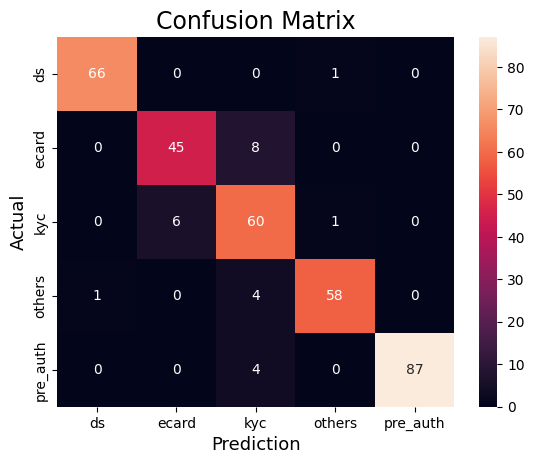

In [18]:
import matplotlib.pyplot as plt
cm_rfc=confusion_matrix(Y_test,pred_rfc)
sns.heatmap(cm_rfc, 
            annot=True,
            fmt='g', 
            xticklabels=['ds','ecard','kyc','others','pre_auth'],
            yticklabels=['ds','ecard','kyc','others','pre_auth'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [19]:
cm_rfc

array([[66,  0,  0,  1,  0],
       [ 0, 45,  8,  0,  0],
       [ 0,  6, 60,  1,  0],
       [ 1,  0,  4, 58,  0],
       [ 0,  0,  4,  0, 87]])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, pred_rfc, target_names=['ds','ecard','kyc','others','pre_auth']))

              precision    recall  f1-score   support

          ds       0.99      0.99      0.99        67
       ecard       0.88      0.85      0.87        53
         kyc       0.79      0.90      0.84        67
      others       0.97      0.92      0.94        63
    pre_auth       1.00      0.96      0.98        91

    accuracy                           0.93       341
   macro avg       0.92      0.92      0.92       341
weighted avg       0.93      0.93      0.93       341



In [25]:
probs=rfc.predict_proba(unigrams_count_test_1)

In [28]:
print(pred_rfc)

['others' 'ds' 'ds' 'others' 'ds' 'pre_auth_form' 'kyc' 'ecard'
 'pre_auth_form' 'ecard' 'kyc' 'kyc' 'ecard' 'kyc' 'pre_auth_form'
 'others' 'pre_auth_form' 'ds' 'ecard' 'ds' 'pre_auth_form' 'ds' 'ds'
 'kyc' 'pre_auth_form' 'kyc' 'ecard' 'ecard' 'pre_auth_form' 'ds' 'others'
 'ds' 'ds' 'kyc' 'others' 'others' 'ecard' 'others' 'pre_auth_form'
 'others' 'others' 'kyc' 'kyc' 'ds' 'ecard' 'ds' 'ecard' 'kyc'
 'pre_auth_form' 'others' 'ds' 'kyc' 'others' 'pre_auth_form' 'kyc'
 'pre_auth_form' 'pre_auth_form' 'pre_auth_form' 'ds' 'pre_auth_form'
 'kyc' 'ecard' 'ds' 'kyc' 'pre_auth_form' 'kyc' 'pre_auth_form'
 'pre_auth_form' 'ds' 'kyc' 'kyc' 'pre_auth_form' 'others' 'others'
 'ecard' 'pre_auth_form' 'ecard' 'ds' 'pre_auth_form' 'pre_auth_form'
 'ecard' 'kyc' 'ds' 'ecard' 'pre_auth_form' 'pre_auth_form' 'others' 'ds'
 'pre_auth_form' 'kyc' 'kyc' 'kyc' 'others' 'pre_auth_form' 'kyc' 'others'
 'others' 'ds' 'others' 'kyc' 'pre_auth_form' 'ecard' 'pre_auth_form' 'ds'
 'kyc' 'ecard' 'pre_auth_form

In [30]:
probs[0:5]

array([[0.04566667, 0.        , 0.        , 0.95433333, 0.        ],
       [0.73652381, 0.05333333, 0.        , 0.13766667, 0.07247619],
       [0.8807619 , 0.        , 0.005     , 0.0892381 , 0.025     ],
       [0.13581818, 0.009     , 0.036     , 0.81118182, 0.008     ],
       [0.90685714, 0.        , 0.        , 0.044     , 0.04914286]])

In [50]:
#printing train and test accuracies
accuracy_score_rfc=metrics.accuracy_score(pred_rfc,Y_test)
print("Train accuracy_RandomForest= ",rfc.score(unigrams_count_train_1,Y_train))
print("Test accuracy_RandomForest= ",accuracy_score_rfc)

Train accuracy_RandomForest=  0.9596469104665826
Test accuracy_RandomForest=  0.9266862170087976
